In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")


from epilearn.models.Temporal.LSTM import LSTMModel
from epilearn.models.Temporal.GRU import GRUModel
from epilearn.models.Temporal.Dlinear import DlinearModel
from epilearn.models.Temporal.XGB import XGBModel
from epilearn.models.Temporal.ARIMA import VARMAXModel

from epilearn.data import UniversalDataset
from epilearn.utils import utils, transforms

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 12 # inputs size
horizon = 3 # predicts size


permute = False

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [2]:
# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

# initialize transforms
transformation = transforms.Compose({
                                    'features': [
                                                    transforms.normalize_feat(),

                                                ],
                                    'graph': [
                                                transforms.normalize_adj(),
                                                    
                                            ],
                                    'dynamic_graph': [
                                                        transforms.normalize_adj(),
                                                    
                                                    ],
                                    'states': []
                                    })

# preprocessing dataset
dataset.transforms = transformation

features, adj_norm, adj_dynamic_norm, states = dataset.get_transformed()
mean, std = dataset.transforms.feat_mean, dataset.transforms.feat_std

features = features.to(device)
adj_norm = adj_norm.to(device)
adj_dynamic_norm = adj_dynamic_norm.to(device)

# split data
train_rate = 0.6 
val_rate = 0.2

target_feat_idx = None
target_idx = None

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))

train_original_data = features[:split_line1, :, :]
val_original_data = features[split_line1:split_line2, :, :]
test_original_data = features[split_line2:, :, :]

train_original_states = dataset.states[:split_line1, :, :]
val_original_states = dataset.states[split_line1:split_line2, :, :]
test_original_states = dataset.states[split_line2:, :, :]

train_input, train_target, train_states, train_adj = dataset.generate_dataset(X = train_original_data, Y = train_original_data[..., 0], states = train_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)
val_input, val_target, val_states, val_adj = dataset.generate_dataset(X = val_original_data, Y = val_original_data[..., 0], states = val_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)
test_input, test_target, test_states, test_adj = dataset.generate_dataset(X = test_original_data, Y = test_original_data[..., 0], states = test_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)

# Selecting the first region for both input and target
train_input = train_input[:, :, 0, :]  # Selecting the first region across all timesteps and features
train_target = train_target[:, :, 0]  # Selecting the first region for the target

val_input = val_input[:, :, 0, :]
val_target = val_target[:, :, 0]

test_input = test_input[:, :, 0, :]
test_target = test_target[:, :, 0]

# shape of train_input: (num_samples, num_timesteps, num_features)

# prepare model

# model = GRUModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)

# model = XGBModel(num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon)

model = VARMAXModel(num_features=train_input.shape[2],
            num_timesteps_input=lookback,
            num_timesteps_output=horizon)

# model = LSTMModel(
#             num_features = train_input.shape[2],
#             num_timesteps_input = lookback,
#             num_timesteps_output = horizon
#             ).to(device = device)


# model = DlinearModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)





In [3]:
train_input.shape

torch.Size([309, 12, 4])

In [4]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        # graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True,
        batch_size = batch_size,
        epochs = epochs)

/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs

MSE Loss: 0.09764311390775722


/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[array([-0.89768603, -0.53483266, -0.11114843]),
 array([-0.5324799 , -0.0825422 ,  0.18990693]),
 array([-0.21796302, -0.68516089, -0.73115543]),
 array([-0.16852573, -0.53741154, -0.77472414]),
 array([-0.25617416, -0.46976384, -0.50871419]),
 array([-0.27535341, -0.32780338, -0.29074991]),
 array([-0.4151027 , -0.26549122, -0.13403375]),
 array([-0.57436389, -0.61710932, -0.45884514]),
 array([-0.27473575, -0.04867879, -0.25972537]),
 array([-0.3069279 , -0.19528919, -0.3245291 ])]

In [ ]:

def get_MAE(pred, target):
    return torch.mean(torch.absolute(pred - target))

# evaluate
out = model.predict(feature = test_input)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = get_MAE(preds, targets)
print(f"MAE: {mae.item()}")



In [ ]:
import matplotlib.pyplot as plt
import torch

out = model.predict(feature=train_input).detach().cpu()

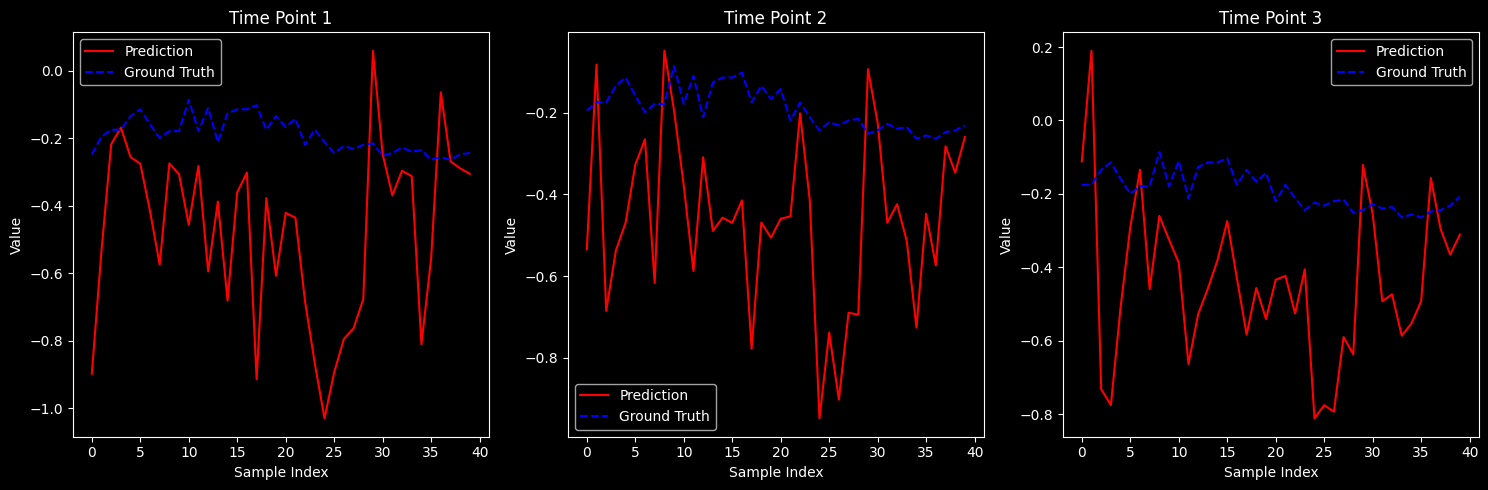

In [7]:
num_samples = 40  # Number of samples to display
time_points = 3  # Each sample predicts the next 3 time points

plt.figure(figsize=(15, 5))
for t in range(time_points):
    plt.subplot(1, 3, t + 1)
    
    # Gather all predictions and actual values for the t-th future time point across the first 40 samples
    predictions = out[:num_samples, t]
    truths = train_target[:num_samples, t]

    # Plotting the predictions and ground truth values
    plt.plot(range(num_samples), predictions.numpy(), 'r-', label='Prediction')
    plt.plot(range(num_samples), truths.numpy(), 'b--', label='Ground Truth')
    plt.title(f"Time Point {t + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()